In [52]:
import numpy as np
import pandas as pd
import os
import math
import random
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as met
from matplotlib import pyplot as plt

from fuzzy import *

In [70]:
class FuzzyKNN:
    def __init__(self, sensitivity, exp_bound):
        # konstruktor
        self.sensitivity = sensitivity
        self.hyperboxes = None
        self.classes = np.array([])
        self.exp_bound = exp_bound
        
    def membership(self, pattern):
        # racuna pripadnost i vraca niz pripadnosti svakom hiperboksu
        min_pts = self.hyperboxes[:, 0, :]
        max_pts = self.hyperboxes[:, 1, :]

        a = np.maximum(0, (1 - np.maximum(0, (self.sensitivity * np.minimum(1, pattern - max_pts)))))
        b = np.maximum(0, (1 - np.maximum(0, (self.sensitivity * np.minimum(1, min_pts - pattern)))))
        
        return np.sum(a + b, axis=1) / (2 * len(pattern))
    
    def overlap_contract(self, index):
        #proveravamo da li se hiperboksevi preklapaju
        contracted = False
        for test_box in range(len(self.hyperboxes)):
            if self.classes[test_box] == self.classes[index]:
                # ignorisemo preklapanje hiperbokseva iste klase
                continue
            expanded_box = self.hyperboxes[index]
            box = self.hyperboxes[test_box]
            
            vj, wj = expanded_box #onaj za koji gledamo da li se preklapa sa nekim
            vk, wk = box

            # moguci slucajevi preklapanja
            # trazimo najmanje preklapanje
            delta_new = delta_old = 1
            min_overlap_index = -1
            for i in range(len(vj)):
                if vj[i] < vk[i] < wj[i] < wk[i]:
                    delta_new = min(delta_old, wj[i] - vk[i])
                elif vk[i] < vj[i] < wk[i] < wj[i]:
                    delta_new = min(delta_old, wk[i] - vj[i])
                
                elif vj[i] < vk[i] < wk[i] < wj[i]:
                    delta_new = min(delta_old, min(wj[i] - vk[i], wk[i] - vj[i]))

                elif vk[i] < vj[i] < wj[i] < wk[i]:
                    delta_new = min(delta_old, min(wj[i] - vk[i], wk[i] - vj[i]))

                if delta_old - delta_new > 0:
                    min_overlap_index = i
                    delta_old = delta_new

            # ako ima preklapanja, 
            # gledamo po kojoj strani smanjujemo hiperbokseve
            if min_overlap_index >= 0:
                i = min_overlap_index
                if vj[i] < vk[i] < wj[i] < wk[i]:
                    vk[i] = wj[i] = (vk[i] + wj[i])/2

                elif vk[i] < vj[i] < wk[i] < wj[i]:
                    vj[i] = wk[i] = (vj[i] + wk[i])/2

                elif vj[i] < vk[i] < wk[i] < wj[i]:
                    if (wj[i] - vk[i]) > (wk[i] - vj[i]):
                        vj[i] = wk[i]

                    else:
                        wj[i] = vk[i]

                elif vk[i] < vj[i] < wj[i] < wk[i]:
                    if (wk[i] - vj[i]) > (wj[i] - vk[i]):
                        vk[i] = wj[i]

                    else:
                        wk[i] = vj[i]

                self.hyperboxes[test_box] = np.array([vk, wk])
                self.hyperboxes[index] = np.array([vj, wj])
                contracted = True
                
        return contracted
    
    def train_pattern(self, X, Y):
        # funkcija koja trenira klasifikator
        target = Y
        
        # ako nemamo tu klasu u klasama
        if target not in self.classes:
            # pravimo hiperboks
            if self.hyperboxes is not None:
                self.hyperboxes = np.vstack((self.hyperboxes, np.array([[X, X]])))
                #print('dodao sam hiperboks: ', self.hyperboxes)
                self.classes = np.hstack((self.classes, np.array([target])))
                #print('dodao sam klasu: ', self.classes)

            else:
                self.hyperboxes = np.array([[X, X]])
                self.classes = np.array([target])
        else:

            # sortiramo pripadnosti svim hiperboksevima za trazenu klasu
            memberships = self.membership(X)
            #print('memberships1: ', memberships)
            memberships[np.where(self.classes != target)] = 0
            #print('memberships2: ', memberships)
            memberships = sorted(list(enumerate(memberships)), key=lambda x: x[1], reverse=True)
            #print('memberships3: ', memberships)
            
            # Sirimo hiperboks
            count = 0
            while True:
                index = memberships[count][0]
                min_new = np.minimum(self.hyperboxes[index, 0, :], X)
                max_new = np.maximum(self.hyperboxes[index, 1, :], X)
                
                if self.exp_bound * len(np.unique(self.classes)) >= np.sum(max_new - min_new):
                    self.hyperboxes[index, 0] = min_new
                    self.hyperboxes[index, 1] = max_new
                    break
                else:
                    count += 1

                if count == len(memberships):
                    self.hyperboxes = np.vstack((self.hyperboxes, np.array([[X, X]])))
                    self.classes = np.hstack((self.classes, np.array([target])))
                    index = len(self.hyperboxes) - 1
                    break
                    
            contracted = self.overlap_contract(index)
        
    def fit(self, X, Y):
        for x, y in zip(X, Y):
            self.train_pattern(x, y)

    
    # predvidjamo klasu
    def predict(self, X, k):
        
        #uzimamo tacke koje odredjuju hiperbokseve
        min_pts = self.hyperboxes[:, 0, :]
        max_pts = self.hyperboxes[:, 1, :]
      
        # broj klasa 
        # i niz u kome cemo brojati pojavljivanje svake klase
        n_classes = len(np.unique(self.classes))
        cl = np.zeros(n_classes)
        
        # racunamo udaljenost tacke X od svakog hiperboksa
        # tako sto racunamo udaljenost X od prave koja prolazi kroz tacke koje odredjuju hiperboks
        distance = []
        for i in range(len(min_pts)):
            x1 = min_pts[i][0]
            y1 = min_pts[i][1]
            x2 = max_pts[i][0]
            y2 = max_pts[i][1]
            
            if(x1 == x2 and y1 == y2):
                d = abs(math.sqrt((x1-X[0])**2 + (y1 - X[1])**2))
                distance.append(d)
            elif(x1 == x2):
                d = min(abs(math.sqrt((x1-X[0])**2 + (y1 - X[1])**2)), 
                       abs(math.sqrt((x2-X[0])**2 + (y2 - X[1])**2)))
                distance.append(d)
            elif(y1 == y2):
                d = min(abs(math.sqrt((x1-X[0])**2 + (y1 - X[1])**2)), 
                       abs(math.sqrt((x2-X[0])**2 + (y2 - X[1])**2)))
                distance.append(d)
            else:
               # print('(x1, y1): ', x1, " ", y1, end="\n")
               # print('(x2, y2): ', x2, " ", y2, end="\n")
                d = abs((y2-y1)*X[0] - (x2-x1)*X[1] + x2*y1 - y2*x1) / math.sqrt((y2-y1)**2 + (x2-x1)**2)
                distance.append(d)

        # sortiramo udaljenosti od najmanje ka najvecoj
        # i uzimamo prvih k najblizih hiperbokseva
        distance = sorted(list(enumerate(distance)), key=lambda x: x[1])
        #print('distance: ', distance, end='\n')
        distance = distance[:k]
        #print('distance_k: ', distance, end='\n')
        distance_index = []
        for i in range(len(distance)):
            distance_index.append(distance[i][0])
            
        # brojimo pojavljivanje svake klase na osnovu hiperboksa koji joj pripada
        for i in range(len(distance_index)):
            index = distance_index[i]
            _class = self.classes[index]
            cl[_class] += 1
            #print('cl: ', cl, end = "\n")
        
        # nalazimo najbrojniju klasu koja je konacna klasa X
        max = 0
        final_class = 0
        for i in range (len(cl)):
            if(cl[i] >= max):
                max = cl[i]
                final_class = i
        
        
        return final_class
       
    # funkcija koja racuna procenat uspesno klasifikovanih instanci
    def score(self, X, Y, k):
        count = 0
        for x, y in zip(X, Y):
            pred = self.predict(x, k)
            if y == pred:
                count += 1
        print(count)
        print(len(Y))
        
        return count / len(Y)

IRIS dataset

In [71]:
df = pd.read_csv('iris.data', header=None, names=['sepal length', 'sepal width', 'petal length', 'petal width', 'class'])
df = df[~(df['class']=='Iris-virginica')]
#df.head()

df.replace(to_replace='Iris-setosa', value=0, inplace=True)

df.replace(to_replace='Iris-versicolor', value=1, inplace=True)

print(df.sample(frac=1))

X_train = df[['sepal length', 'petal length']].values
Y_train = df['class'].values

_max = np.max(X_train, axis=0)
_min = np.min(X_train, axis=0)
X_train = (X_train - _min) / (_max - _min)
print(X_train)

    sepal length  sepal width  petal length  petal width  class
23           5.1          3.3           1.7          0.5      0
42           4.4          3.2           1.3          0.2      0
3            4.6          3.1           1.5          0.2      0
91           6.1          3.0           4.6          1.4      1
31           5.4          3.4           1.5          0.4      0
..           ...          ...           ...          ...    ...
8            4.4          2.9           1.4          0.2      0
30           4.8          3.1           1.6          0.2      0
37           4.9          3.1           1.5          0.1      0
1            4.9          3.0           1.4          0.2      0
43           5.0          3.5           1.6          0.6      0

[100 rows x 5 columns]
[[0.2962963  0.09756098]
 [0.22222222 0.09756098]
 [0.14814815 0.07317073]
 [0.11111111 0.12195122]
 [0.25925926 0.09756098]
 [0.40740741 0.17073171]
 [0.11111111 0.09756098]
 [0.25925926 0.12195122]
 [0.0370

In [72]:
X_test, Y_test = X_train[-20:], Y_train[-20:]
X_train, Y_train = X_train[:-20], Y_train[:-20]
(Y_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [73]:
clf1 = FuzzyKNN(sensitivity=1, exp_bound=0.4)
clf1.fit(X_train, Y_train)
score1 = clf1.score(X_test, Y_test, 4)
(score1)

16
20


0.8

Fuzzy Min-Max Classificator - IRIS

In [74]:
clf2 = FuzzyMMC(sensitivity=1, exp_bound=0.4)
clf2.fit(X_train, Y_train)
score2 = clf2.score(X_test, Y_test)
(score2)

0.85

KNN algoritam

In [75]:
clf3 = KNeighborsClassifier(n_neighbors = 4)
clf3.fit(X_train, Y_train)
Y_pred = clf3.predict(X_test)
accuracy = met.accuracy_score(Y_test, Y_pred)
(accuracy)

1.0

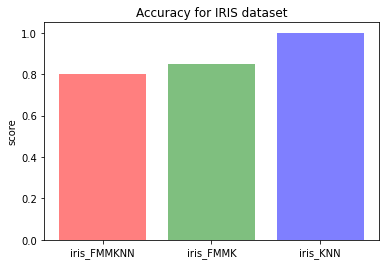

In [76]:
# IRIS poredjenje
objects = ('iris_FMMKNN', 'iris_FMMK', 'iris_KNN')
y_pos = np.arange(len(objects))

x_pos = [score1, score2, accuracy] 

plt.bar(y_pos, x_pos, align='center', alpha=0.5, color = ['r', 'g','b'])
plt.xticks(y_pos, objects)
plt.ylabel('score')
plt.title('Accuracy for IRIS dataset')

plt.show()

WINE dataset

In [77]:
print("\n---------------------------------\nWINE DATASET: \n\n")
df = pd.read_csv('wine.csv')
df.head()

df.replace(to_replace=1, value=0, inplace=True)
df.replace(to_replace=2, value=1, inplace=True)
df.replace(to_replace=3, value=2, inplace=True)

print(df.sample(frac=1))

X_train = df[['Alcohol', 'Malic.acid']].values
Y_train = df['Wine'].values
_max = np.max(X_train, axis=0)
_min = np.min(X_train, axis=0)
X_train = (X_train - _min) / (_max - _min)
print(X_train)
print(Y_train)


---------------------------------
WINE DATASET: 


     Wine  Alcohol  Malic.acid   Ash   Acl   Mg  Phenols  Flavanoids  \
54      0    13.74        1.67  2.25  16.4  118     2.60        2.90   
129     1    12.04        4.30  2.38  22.0   80     2.10        1.75   
128     1    12.37        1.63  2.30  24.5   88     2.22        2.45   
92      1    12.69        1.53  2.26  20.7   80     1.38        1.46   
67      1    12.37        1.17  1.92  19.6   78     2.11        1.00   
..    ...      ...         ...   ...   ...  ...      ...         ...   
73      1    12.99        1.67  2.60  30.0  139     3.30        2.89   
91      1    12.00        1.51  2.42  22.0   86     1.45        1.25   
154     2    12.58        1.29  2.10  20.0  103     1.48        0.58   
61      1    12.64        1.36  2.02  16.8  100     2.02        1.41   
144     2    12.25        3.88  2.20  18.5  112     1.38        0.78   

     Nonflavanoid.phenols  Proanth  Color.int   Hue    OD  Proline  
54            

In [78]:
X_test, Y_test = X_train[-20:], Y_train[-20:]
X_train, Y_train = X_train[:-20], Y_train[:-20]
(Y_test)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Fuzzy Min-Max Classificator - WINE

In [79]:
clf2 = FuzzyMMC(sensitivity=1, exp_bound=0.4)
clf2.fit(X_train, Y_train)
score2 = clf2.score(X_test, Y_test)
score2

0.65

Algoritam koji koristi KNN

In [80]:
clf1 = FuzzyKNN(sensitivity=1, exp_bound=0.4)
clf1.fit(X_train, Y_train)
score1 = clf1.score(X_test, Y_test, 2)
score1

10
20


0.5

KNN algoritam

In [81]:
clf3 = KNeighborsClassifier(n_neighbors = 4)
clf3.fit(X_train, Y_train)
Y_pred = clf3.predict(X_test)
accuracy = met.accuracy_score(Y_test, Y_pred)
accuracy

0.45

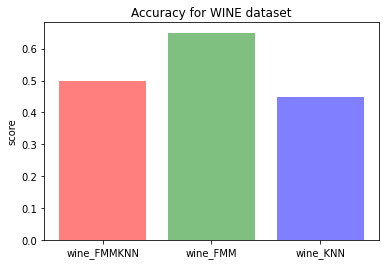

In [82]:
# WINE poredjenje
objects = ('wine_FMMKNN', 'wine_FMM', 'wine_KNN')
y_pos = np.arange(len(objects))

x_pos = [score1, score2, accuracy] 

plt.bar(y_pos, x_pos, align='center', alpha=0.5, color = ['r', 'g','b'])
plt.xticks(y_pos, objects)
plt.ylabel('score')
plt.title('Accuracy for WINE dataset')

plt.show()